## 1. Setup and Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cpu
CUDA available: False


## 2. Data Ingestion

Load the raw weather CSV data and perform basic cleaning.

In [2]:
# Load raw data
raw_data_path = 'data/terai_districts_weather.csv'
df_raw = pd.read_csv(raw_data_path, parse_dates=['Date'])

# Normalize column names
df_raw.columns = [c.strip() for c in df_raw.columns]

# Basic info
print(f"Data shape: {df_raw.shape}")
print(f"\nColumns: {df_raw.columns.tolist()}")
print(f"\nDate range: {df_raw['Date'].min()} to {df_raw['Date'].max()}")
print(f"\nDistricts: {df_raw['District'].nunique()}")
print(df_raw['District'].unique())

df_raw.head()

Data shape: (142440, 23)

Columns: ['SN', 'Date', 'District', 'Latitude', 'Longitude', 'Precip', 'Pressure', 'Humidity_2m', 'RH_2m', 'Temp_2m', 'WetBulbTemp_2m', 'MaxTemp_2m', 'MinTemp_2m', 'TempRange_2m', 'EarthSkinTemp', 'WindSpeed_10m', 'MaxWindSpeed_10m', 'MinWindSpeed_10m', 'WindSpeedRange_10m', 'WindSpeed_50m', 'MaxWindSpeed_50m', 'MinWindSpeed_50m', 'WindSpeedRange_50m']

Date range: 1981-01-01 00:00:00 to 2019-12-31 00:00:00

Districts: 10
['Bara' 'Chitawan' 'Dhanusa' 'Mahottari' 'Makwanpur' 'Saptari' 'Sarlahi'
 'Sindhuli' 'Sunsari' 'Udayapur']


,SN,Date,District,Latitude,Longitude,Precip,Pressure,Humidity_2m,RH_2m,Temp_2m,...,TempRange_2m,EarthSkinTemp,WindSpeed_10m,MaxWindSpeed_10m,MinWindSpeed_10m,WindSpeedRange_10m,WindSpeed_50m,MaxWindSpeed_50m,MinWindSpeed_50m,WindSpeedRange_50m
0,1,1981-01-01,Bara,27.2,85.0,0.00,95.66,5.20,48.44,14.46,...,11.96,12.57,1.71,3.48,0.25,3.22,2.22,3.46,0.35,3.10
1,2,1981-01-02,Bara,27.2,85.0,0.00,95.72,5.14,46.55,14.87,...,11.94,12.82,1.61,2.62,1.01,1.61,2.12,3.06,1.30,1.76
2,3,1981-01-03,Bara,27.2,85.0,0.00,95.68,5.50,48.78,15.20,...,11.52,13.46,1.86,2.85,0.84,2.02,2.46,3.42,0.93,2.49
3,4,1981-01-04,Bara,27.2,85.0,0.01,95.64,5.66,50.37,15.16,...,11.10,13.56,1.92,3.18,0.30,2.88,2.55,3.48,0.34,3.14
4,5,1981-01-05,Bara,27.2,85.0,0.31,95.62,5.66,50.33,15.13,...,11.28,13.77,1.98,2.77,0.94,1.83,2.71,3.90,1.32,2.58


In [3]:
# Check for missing values
print("Missing values per column:")
print(df_raw.isnull().sum())

# Save processed version
os.makedirs('data/processed', exist_ok=True)
df_raw.to_parquet('data/processed/weather.parquet', index=False)
print("\n✓ Saved to data/processed/weather.parquet")

Missing values per column:
SN                    0
Date                  0
District              0
Latitude              0
Longitude             0
Precip                0
Pressure              0
Humidity_2m           0
RH_2m                 0
Temp_2m               0
WetBulbTemp_2m        0
MaxTemp_2m            0
MinTemp_2m            0
TempRange_2m          0
EarthSkinTemp         0
WindSpeed_10m         0
MaxWindSpeed_10m      0
MinWindSpeed_10m      0
WindSpeedRange_10m    0
WindSpeed_50m         0
MaxWindSpeed_50m      0
MinWindSpeed_50m      0
WindSpeedRange_50m    0
dtype: int64

✓ Saved to data/processed/weather.parquet


## 3. Feature Engineering

Create time-based, rolling, lag, and anomaly features.

In [4]:
def add_time_features(df):
    df = df.copy()
    df['doy'] = df['Date'].dt.dayofyear
    df['doy_sin'] = np.sin(2*np.pi*df['doy']/365.25)
    df['doy_cos'] = np.cos(2*np.pi*df['doy']/365.25)
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    return df

def rolling_lags(df, group='District'):
    df = df.sort_values([group,'Date']).copy()
    g = df.groupby(group)
    
    # Rolling sums/means
    df['precip_3d'] = g['Precip'].rolling(3, min_periods=1).sum().reset_index(0,drop=True)
    df['precip_7d'] = g['Precip'].rolling(7, min_periods=1).sum().reset_index(0,drop=True)
    df['maxT_3d_mean'] = g['MaxTemp_2m'].rolling(3, min_periods=1).mean().reset_index(0,drop=True)
    df['temp_range_3d_max'] = g['TempRange_2m'].rolling(3, min_periods=1).max().reset_index(0,drop=True)
    
    # Lags for precip and temp
    for lag in [1,2,3,7,14]:
        df[f'precip_lag_{lag}'] = g['Precip'].shift(lag)
        df[f'maxT_lag_{lag}'] = g['MaxTemp_2m'].shift(lag)
    
    # API-like index
    alpha = 0.8
    def compute_api(s):
        api = []
        prev = 0.0
        for v in s.fillna(0):
            prev = alpha*prev + v
            api.append(prev)
        return pd.Series(api, index=s.index)
    df['API'] = g['Precip'].apply(lambda s: compute_api(s)).reset_index(0,drop=True)
    return df

def climatology_anomaly(df):
    df = df.copy()
    df['doy'] = df['Date'].dt.dayofyear
    climatology = df.groupby(['District','doy'])[['MaxTemp_2m','Precip']].median().rename(
        columns={'MaxTemp_2m':'clim_maxT','Precip':'clim_precip'}).reset_index()
    df = df.merge(climatology, on=['District','doy'], how='left')
    df['anom_maxT'] = df['MaxTemp_2m'] - df['clim_maxT']
    df['anom_precip'] = df['Precip'] - df['clim_precip']
    return df

# Apply feature engineering
df = pd.read_parquet('data/processed/weather.parquet')
df = add_time_features(df)
df = rolling_lags(df)
df = climatology_anomaly(df)

print(f"Features created. New shape: {df.shape}")
print(f"\nNew columns added:")
new_cols = [c for c in df.columns if c not in df_raw.columns]
print(new_cols)

df.head()

Features created. New shape: (142440, 47)

New columns added:
['doy', 'doy_sin', 'doy_cos', 'year', 'month', 'precip_3d', 'precip_7d', 'maxT_3d_mean', 'temp_range_3d_max', 'precip_lag_1', 'maxT_lag_1', 'precip_lag_2', 'maxT_lag_2', 'precip_lag_3', 'maxT_lag_3', 'precip_lag_7', 'maxT_lag_7', 'precip_lag_14', 'maxT_lag_14', 'API', 'clim_maxT', 'clim_precip', 'anom_maxT', 'anom_precip']


,SN,Date,District,Latitude,Longitude,Precip,Pressure,Humidity_2m,RH_2m,Temp_2m,...,maxT_lag_3,precip_lag_7,maxT_lag_7,precip_lag_14,maxT_lag_14,API,clim_maxT,clim_precip,anom_maxT,anom_precip
0,1,1981-01-01,Bara,27.2,85.0,0.00,95.66,5.20,48.44,14.46,...,NaN,NaN,NaN,NaN,NaN,0.000,21.85,0.0,-0.15,0.00
1,2,1981-01-02,Bara,27.2,85.0,0.00,95.72,5.14,46.55,14.87,...,NaN,NaN,NaN,NaN,NaN,0.000,21.98,0.0,0.10,0.00
2,3,1981-01-03,Bara,27.2,85.0,0.00,95.68,5.50,48.78,15.20,...,NaN,NaN,NaN,NaN,NaN,0.000,22.24,0.0,0.00,0.00
3,4,1981-01-04,Bara,27.2,85.0,0.01,95.64,5.66,50.37,15.16,...,21.70,NaN,NaN,NaN,NaN,0.010,22.01,0.0,0.00,0.01
4,5,1981-01-05,Bara,27.2,85.0,0.31,95.62,5.66,50.33,15.13,...,22.08,NaN,NaN,NaN,NaN,0.318,21.86,0.0,-0.20,0.31


## 4. Labeling

Create target labels for heatwave and flood events.

In [5]:
def label_heatwave(df, pct=0.95, min_run=3, temp_col='MaxTemp_2m'):
    df = df.sort_values(['District','Date']).copy()
    # Compute district-specific percentile
    p = df.groupby('District')[temp_col].transform(lambda s: s.quantile(pct))
    df['heat_exceed'] = df[temp_col] > p
    
    # Compute run length of consecutive True values
    def run_len(s):
        runs = s.astype(int).groupby((s != s.shift()).cumsum()).cumsum() * s
        return runs
    df['heat_run'] = df.groupby('District')['heat_exceed'].transform(lambda s: run_len(s))
    df['heatwave'] = df['heat_run'] >= min_run
    return df

def label_flood(df, p1_pct=0.99, p3_pct=0.98):
    df = df.sort_values(['District','Date']).copy()
    g = df.groupby('District')
    df['precip_1d'] = df['Precip'].fillna(0)
    df['precip_3d'] = g['precip_1d'].rolling(3, min_periods=1).sum().reset_index(0,drop=True)
    df['precip_7d'] = g['precip_1d'].rolling(7, min_periods=1).sum().reset_index(0,drop=True)
    
    # Thresholds
    p99 = g['precip_1d'].transform(lambda s: s.quantile(p1_pct))
    p98_3d = g['precip_3d'].transform(lambda s: s.quantile(p3_pct))
    df['precip_p99'] = p99
    df['precip3_p98'] = p98_3d
    
    # Wetness flag
    df['RH_2m_filled'] = df['RH_2m'].fillna(method='ffill').fillna(method='bfill')
    df['wetness_flag'] = df['RH_2m_filled'] > g['RH_2m_filled'].transform(lambda s: s.quantile(0.9))
    df['flood_proxy'] = ((df['precip_1d'] > df['precip_p99']) | (df['precip_3d'] > df['precip3_p98'])) & df['wetness_flag']
    return df

# Apply labeling
df = label_heatwave(df)
df = label_flood(df)

# Save labeled data
df.to_parquet('data/processed/weather_labeled.parquet', index=False)
print("✓ Saved labeled data")

# Show label statistics
print(f"\nHeatwave events: {df['heatwave'].sum()} ({df['heatwave'].mean()*100:.2f}%)")
print(f"Flood events: {df['flood_proxy'].sum()} ({df['flood_proxy'].mean()*100:.2f}%)")

df[['Date', 'District', 'MaxTemp_2m', 'Precip', 'heatwave', 'flood_proxy']].head(20)

✓ Saved labeled data

Heatwave events: 3794 (2.66%)
Flood events: 2175 (1.53%)


,Date,District,MaxTemp_2m,Precip,heatwave,flood_proxy
0,1981-01-01,Bara,21.70,0.00,False,False
1,1981-01-02,Bara,22.08,0.00,False,False
2,1981-01-03,Bara,22.24,0.00,False,False
3,1981-01-04,Bara,22.01,0.01,False,False
4,1981-01-05,Bara,21.66,0.31,False,False
5,1981-01-06,Bara,21.67,0.68,False,False
6,1981-01-07,Bara,17.50,0.95,False,False
7,1981-01-08,Bara,19.22,0.67,False,False
8,1981-01-09,Bara,19.01,0.22,False,False
9,1981-01-10,Bara,20.42,0.00,False,False


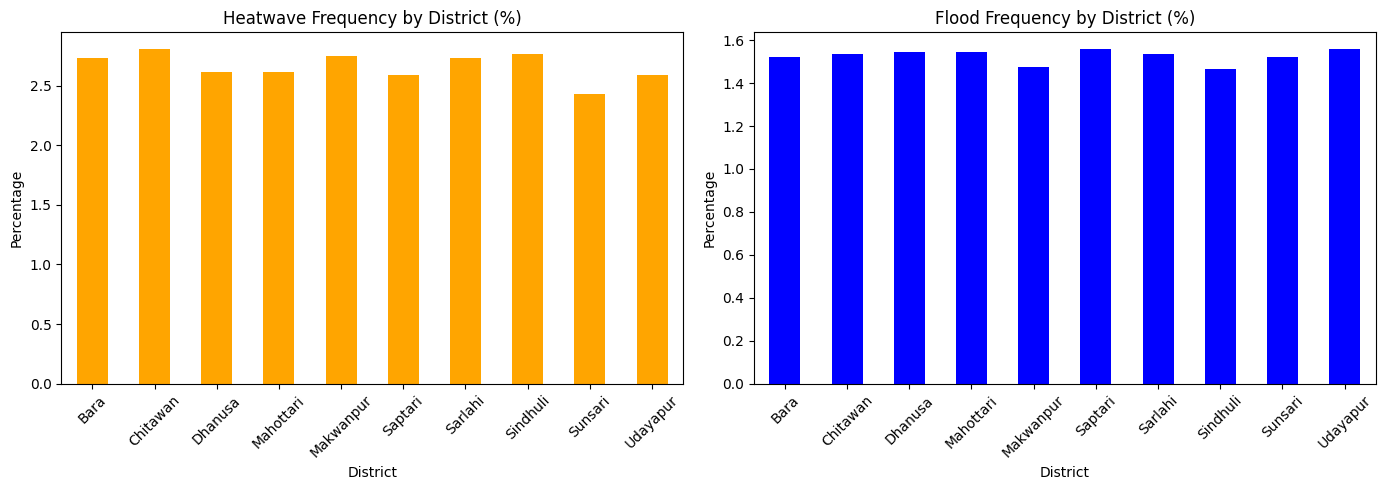

In [6]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatwave distribution by district
heatwave_by_district = df.groupby('District')['heatwave'].mean() * 100
heatwave_by_district.plot(kind='bar', ax=axes[0], color='orange')
axes[0].set_title('Heatwave Frequency by District (%)')
axes[0].set_ylabel('Percentage')
axes[0].tick_params(axis='x', rotation=45)

# Flood distribution by district
flood_by_district = df.groupby('District')['flood_proxy'].mean() * 100
flood_by_district.plot(kind='bar', ax=axes[1], color='blue')
axes[1].set_title('Flood Frequency by District (%)')
axes[1].set_ylabel('Percentage')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. LSTM Model Architecture

Define the LSTM model for binary classification.

In [7]:
class LSTMModel(nn.Module):
    """LSTM model for binary classification."""
    def __init__(self, input_size, hidden_size=64, fc_size=32):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, fc_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_size, 1)
    
    def forward(self, x):
        # x shape: (batch, timesteps, features)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # Use last hidden state
        out = self.fc1(h_n[-1])
        out = self.relu(out)
        out = self.fc2(out)
        return out.squeeze(-1)  # Returns logits

print("✓ LSTM model architecture defined")

✓ LSTM model architecture defined


## 6. Sequence Building

Create sequences from time series data for LSTM training.

In [8]:
def build_sequences(df, timesteps=14, target='heatwave'):
    """
    Build sequences for LSTM training.
    
    Args:
        df: DataFrame with features and labels
        timesteps: Number of timesteps in each sequence
        target: Target column name ('heatwave' or 'flood_proxy')
    
    Returns:
        X: Array of sequences (n_samples, timesteps, n_features)
        y: Array of labels (n_samples,)
        feature_cols: List of feature column names
    """
    df = df.sort_values(['District','Date']).copy()
    
    # Exclude non-feature columns
    exclude_cols = ['Date', 'District', 'heatwave', 'flood_proxy', 'heat_exceed', 'heat_run',
                    'precip_1d', 'precip_p99', 'precip3_p98', 'RH_2m_filled', 'wetness_flag']
    feature_cols = [c for c in df.columns if c not in exclude_cols]
    
    sequences = []
    targets = []
    
    for district, g in df.groupby('District'):
        arr = g[feature_cols].values
        lab = g[target].fillna(False).astype(int).values
        
        if len(arr) < timesteps + 1:
            continue
        
        for i in range(timesteps, len(arr)):
            seq = arr[i-timesteps:i]
            sequences.append(seq)
            targets.append(lab[i])
    
    X = np.array(sequences, dtype=np.float32)
    y = np.array(targets, dtype=np.float32)
    
    # Replace NaN and inf values
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    return X, y, feature_cols

print("✓ Sequence building function defined")

✓ Sequence building function defined


## 7. Training and Evaluation Functions

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device):
    """Evaluate model on validation/test data."""
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            
            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(outputs)
            all_preds.extend(probs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader.dataset)
    auc = roc_auc_score(all_targets, all_preds) if len(set(all_targets)) > 1 else 0.0
    
    return avg_loss, auc, all_preds, all_targets

print("✓ Training and evaluation functions defined")

✓ Training and evaluation functions defined


## 8. Train LSTM Model for Heatwave Prediction

In [10]:
# Configuration
TARGET = 'heatwave'  # or 'flood_proxy'
TIMESTEPS = 14
HIDDEN_SIZE = 64
FC_SIZE = 32
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.001

print(f"Training LSTM for {TARGET} prediction")
print(f"="*80)

# Load labeled data
df_labeled = pd.read_parquet('data/processed/weather_labeled.parquet')

# Build sequences
X, y, feature_cols = build_sequences(df_labeled, timesteps=TIMESTEPS, target=TARGET)
print(f"\nSequences shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"Positive samples: {y.sum()} ({y.mean()*100:.2f}%)")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(f"\nTrain samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training LSTM for heatwave prediction

Sequences shape: (142300, 14, 45)
Labels shape: (142300,)
Number of features: 45
Positive samples: 3794.0 (2.67%)

Train samples: 113840
Test samples: 28460


In [11]:
# Scale features
nsamples, nt, nf = X_train.shape
scaler = StandardScaler()

X_train_flat = X_train.reshape(-1, nf)
X_test_flat = X_test.reshape(-1, nf)

scaler.fit(X_train_flat)
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

print("✓ Features scaled")

✓ Features scaled


In [12]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 890
Test batches: 223


In [13]:
# Setup device, model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = LSTMModel(input_size=nf, hidden_size=HIDDEN_SIZE, fc_size=FC_SIZE).to(device)
criterion = nn.BCEWithLogitsLoss()  # More numerically stable
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\nModel architecture:")
print(f"  Input size: {nf}")
print(f"  Hidden size: {HIDDEN_SIZE}")
print(f"  FC size: {FC_SIZE}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters())}")

Using device: cpu

Model architecture:
  Input size: 45
  Hidden size: 64
  FC size: 32
  Parameters: 30529


In [14]:
# Training loop
history = {
    'train_loss': [],
    'val_loss': [],
    'val_auc': []
}

print(f"\n{'='*80}")
print("TRAINING")
print(f"{'='*80}\n")

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_auc, _, _ = evaluate(model, test_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    
    print(f'Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val AUC: {val_auc:.4f}')

print(f"\n{'='*80}")
print("TRAINING COMPLETE")
print(f"{'='*80}")


TRAINING

Epoch 1/20 - Train Loss: 0.0513 - Val Loss: 0.0231 - Val AUC: 0.9973
Epoch 2/20 - Train Loss: 0.0235 - Val Loss: 0.0259 - Val AUC: 0.9974
Epoch 3/20 - Train Loss: 0.0218 - Val Loss: 0.0208 - Val AUC: 0.9978
Epoch 4/20 - Train Loss: 0.0206 - Val Loss: 0.0215 - Val AUC: 0.9978
Epoch 5/20 - Train Loss: 0.0192 - Val Loss: 0.0177 - Val AUC: 0.9983
Epoch 6/20 - Train Loss: 0.0186 - Val Loss: 0.0180 - Val AUC: 0.9983
Epoch 7/20 - Train Loss: 0.0174 - Val Loss: 0.0176 - Val AUC: 0.9983
Epoch 8/20 - Train Loss: 0.0166 - Val Loss: 0.0164 - Val AUC: 0.9985
Epoch 9/20 - Train Loss: 0.0155 - Val Loss: 0.0179 - Val AUC: 0.9984
Epoch 10/20 - Train Loss: 0.0146 - Val Loss: 0.0160 - Val AUC: 0.9987
Epoch 11/20 - Train Loss: 0.0137 - Val Loss: 0.0163 - Val AUC: 0.9986
Epoch 12/20 - Train Loss: 0.0131 - Val Loss: 0.0154 - Val AUC: 0.9987
Epoch 13/20 - Train Loss: 0.0122 - Val Loss: 0.0152 - Val AUC: 0.9988
Epoch 14/20 - Train Loss: 0.0113 - Val Loss: 0.0168 - Val AUC: 0.9985
Epoch 15/20 - Trai

## 9. Model Evaluation and Visualization

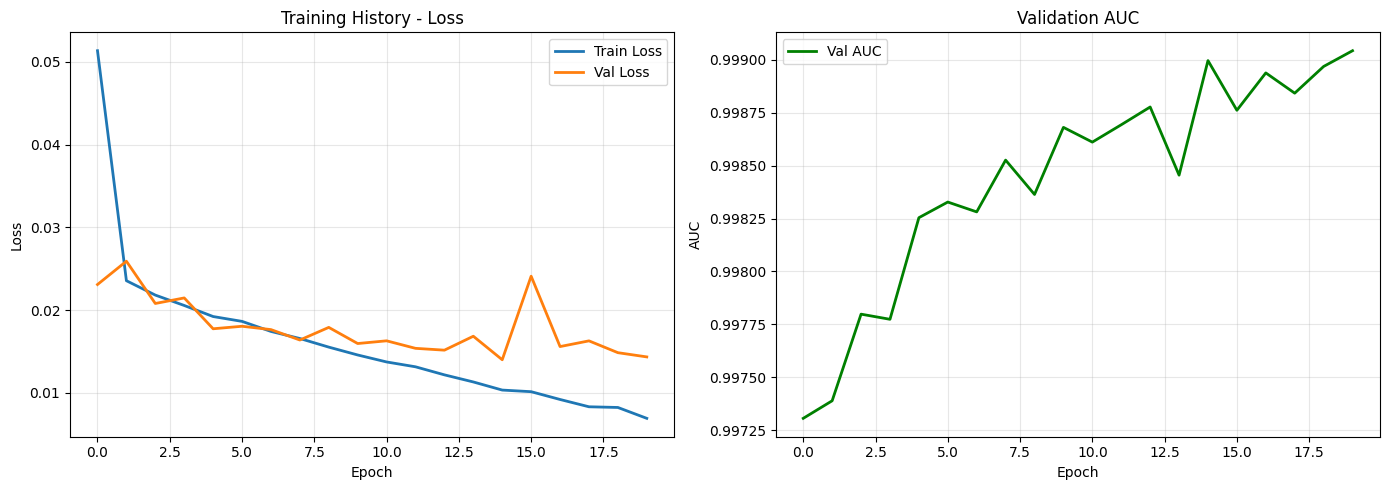

Best Val AUC: 0.9990


In [15]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training History - Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AUC curve
axes[1].plot(history['val_auc'], label='Val AUC', linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Validation AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best Val AUC: {max(history['val_auc']):.4f}")

Classification Report:
              precision    recall  f1-score   support

    No Event       1.00      1.00      1.00     27661
       Event       0.90      0.91      0.90       799

    accuracy                           0.99     28460
   macro avg       0.95      0.95      0.95     28460
weighted avg       0.99      0.99      0.99     28460



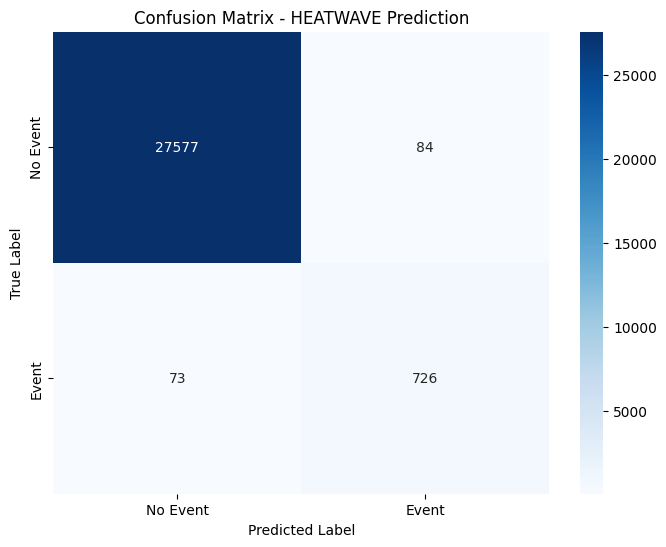

In [16]:
# Get final predictions
_, _, test_probs, test_targets = evaluate(model, test_loader, criterion, device)
test_preds = (np.array(test_probs) > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(test_targets, test_preds, target_names=['No Event', 'Event']))

# Confusion matrix
cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Event', 'Event'],
            yticklabels=['No Event', 'Event'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix - {TARGET.upper()} Prediction')
plt.show()

## 10. Save Model

In [17]:
# Save model
os.makedirs('models', exist_ok=True)
model_path = f'models/lstm_{TARGET}.pt'

torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': nf,
    'hidden_size': HIDDEN_SIZE,
    'fc_size': FC_SIZE,
    'timesteps': TIMESTEPS,
    'feature_cols': feature_cols,
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
    'history': history
}, model_path)

print(f"✓ Model saved to {model_path}")

✓ Model saved to models/lstm_heatwave.pt


## 11. Load Model and Make Predictions

In [22]:
# Load saved model
checkpoint = torch.load(model_path ,weights_only=False)

loaded_model = LSTMModel(
    input_size=checkpoint['input_size'],
    hidden_size=checkpoint['hidden_size'],
    fc_size=checkpoint['fc_size']
).to(device)

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

print(f"✓ Model loaded from {model_path}")
print(f"  Timesteps: {checkpoint['timesteps']}")
print(f"  Features: {checkpoint['input_size']}")
print(f"  Best Val AUC: {max(checkpoint['history']['val_auc']):.4f}")

✓ Model loaded from models/lstm_heatwave.pt
  Timesteps: 14
  Features: 45
  Best Val AUC: 0.9990


In [23]:
# Make predictions on new data
def predict_sequence(model, scaler, sequence, device):
    """
    Make prediction for a single sequence.
    
    Args:
        model: Trained LSTM model
        scaler: Fitted StandardScaler
        sequence: Numpy array of shape (timesteps, n_features)
        device: torch device
    
    Returns:
        probability: Float probability of positive class
    """
    model.eval()
    
    # Scale sequence
    seq_scaled = scaler.transform(sequence)
    
    # Convert to tensor
    X = torch.FloatTensor(seq_scaled).unsqueeze(0).to(device)
    
    with torch.no_grad():
        logits = model(X)
        prob = torch.sigmoid(logits).cpu().item()
    
    return prob

# Example: Predict on first test sample
sample_idx = 0
sample_seq = X_test[sample_idx]
true_label = y_test[sample_idx]

# Recreate scaler from saved parameters
loaded_scaler = StandardScaler()
loaded_scaler.mean_ = checkpoint['scaler_mean']
loaded_scaler.scale_ = checkpoint['scaler_scale']

pred_prob = predict_sequence(loaded_model, loaded_scaler, sample_seq, device)

print(f"Sample prediction:")
print(f"  True label: {int(true_label)}")
print(f"  Predicted probability: {pred_prob:.4f}")
print(f"  Predicted class: {int(pred_prob > 0.5)}")

Sample prediction:
  True label: 0
  Predicted probability: 0.0000
  Predicted class: 0


## 12. Train Model for Flood Prediction (Optional)

Repeat the same process for flood prediction by changing the TARGET variable.

In [ ]:
# To train flood model, change TARGET to 'flood_proxy' and re-run cells from section 8 onwards
print("To train flood prediction model:")
print("1. Set TARGET = 'flood_proxy' in section 8")
print("2. Re-run cells from section 8 onwards")
print("\nThe model will be saved as models/lstm_flood_proxy.pt")